# Практична робота №6
### Тема: КЛАСИФІКАЦІЯ ТА КЛАСТЕРИЗАЦІЯ.
### Мета: ознайомитись з
• методами класифікації та кластеризації;
• моделями, що використовують дерева прийняття рішень;
• інструментами факторного аналізу методом головних компонент та методом
найбільшої подібності.

### Виконав: ІП-13 Ал Хадам М.Р.
### Перевірила: Ліхоузова Т.А.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.float_format = "{:,.2f}".format

# Основне завдання
# 1. Скачати потрібні дані.
Завантажимо та обробимо дані


In [34]:
df = pd.read_csv("data/titanic.csv")
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Побудуємо теплову карту для пропущених значень кожного зі стовпців

<Axes: >

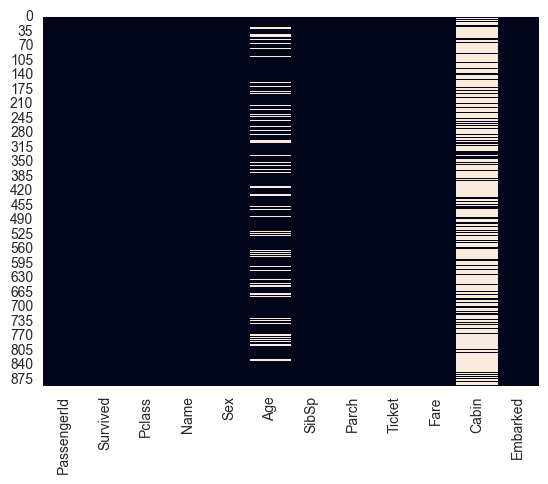

In [35]:
sns.heatmap(df.isnull(), cbar=False)

Побудуємо гістрограми серед виживших пасажирів для кожного зі стовпців

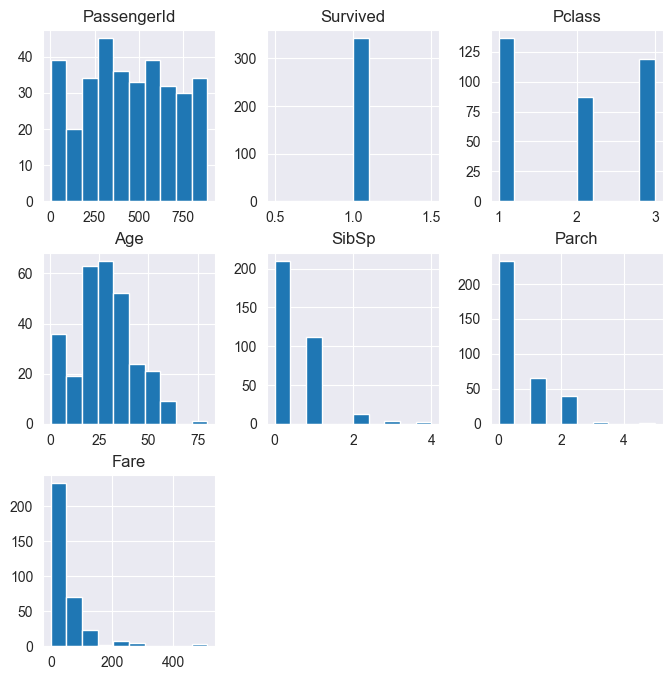

<Axes: >

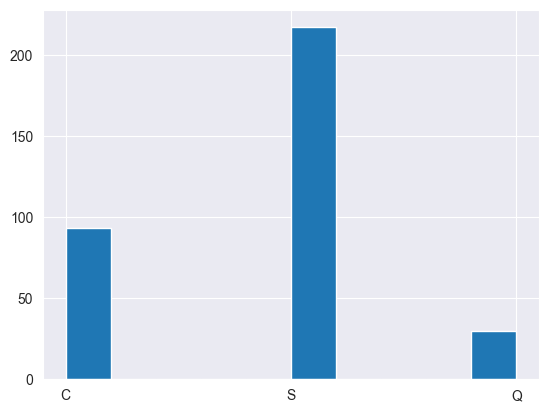

In [36]:
df[df['Survived'] == 1].hist(figsize=(8, 8))
plt.show()
df[df['Survived'] == 1]['Embarked'].hist()

Заповнимо пропущені дані відповдними характеристиками

In [37]:
df = df.fillna(df.mean(numeric_only=True))
df['Cabin'] = df['Cabin'].fillna('')
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = df.set_index('PassengerId')

# for corr matrix (male: 0, female: 1)
df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})

df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [38]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.92,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.05,,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.00,0,0,211536,13.00,,S
888,1,1,"Graham, Miss. Margaret Edith",1,19.00,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.70,1,2,W./C. 6607,23.45,,S


Отже, датасет був первинно обробленний, пусті значення були заповнені

# 2. Для даних по титаніку titanic.csv побудувати модель, в якій можна визначити, чи виживе пасажир, заповнивши решту параметрів.

Побудуємо коваріаційні матриці та діаграми розсіювання

Видалимо string стовпці

In [39]:
df = df.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df

,Survived,Pclass,Sex,Age,Fare
PassengerId,,,,,
1,0,3,0,22.00,7.25
2,1,1,1,38.00,71.28
3,1,3,1,26.00,7.92
4,1,1,1,35.00,53.10
5,0,3,0,35.00,8.05
...,...,...,...,...,...
887,0,2,0,27.00,13.00
888,1,1,1,19.00,30.00
889,0,3,1,29.70,23.45


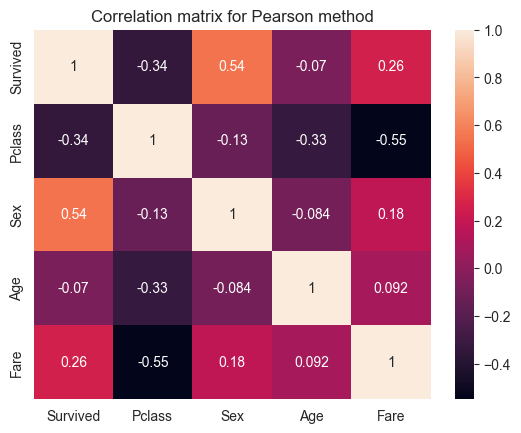

In [40]:
fig, ax = plt.subplots()
pearson_corr = df.corr(method='pearson')

ax.set_title('Correlation matrix for Pearson method')
sns.heatmap(pearson_corr, annot=True)

plt.show()

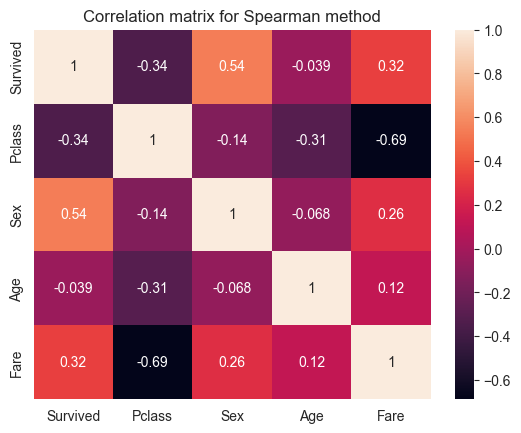

In [41]:
fig, ax = plt.subplots()
pearson_corr = df.corr(method='spearman')

ax.set_title('Correlation matrix for Spearman method')
sns.heatmap(pearson_corr, annot=True)

plt.show()

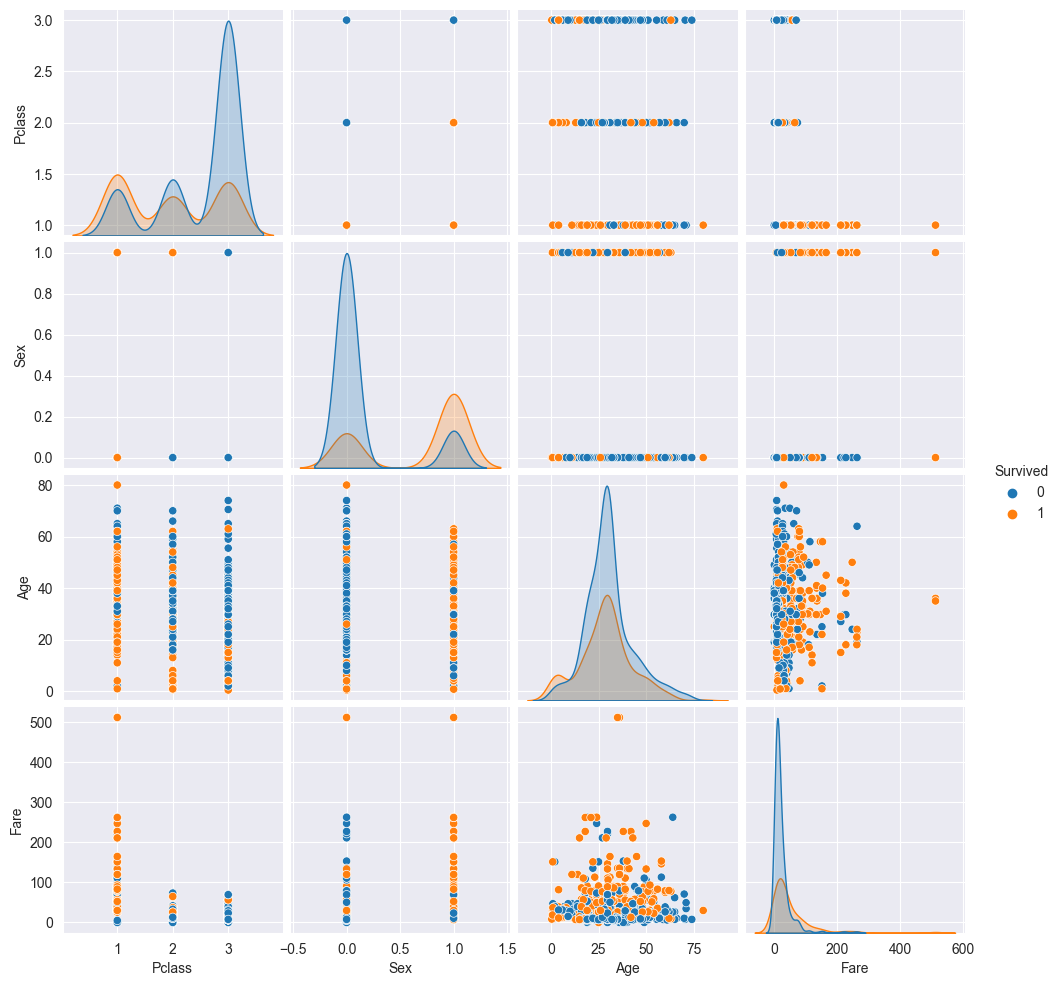

In [42]:
sns.pairplot(df, hue='Survived')

<Figure size 1600x1600 with 0 Axes>

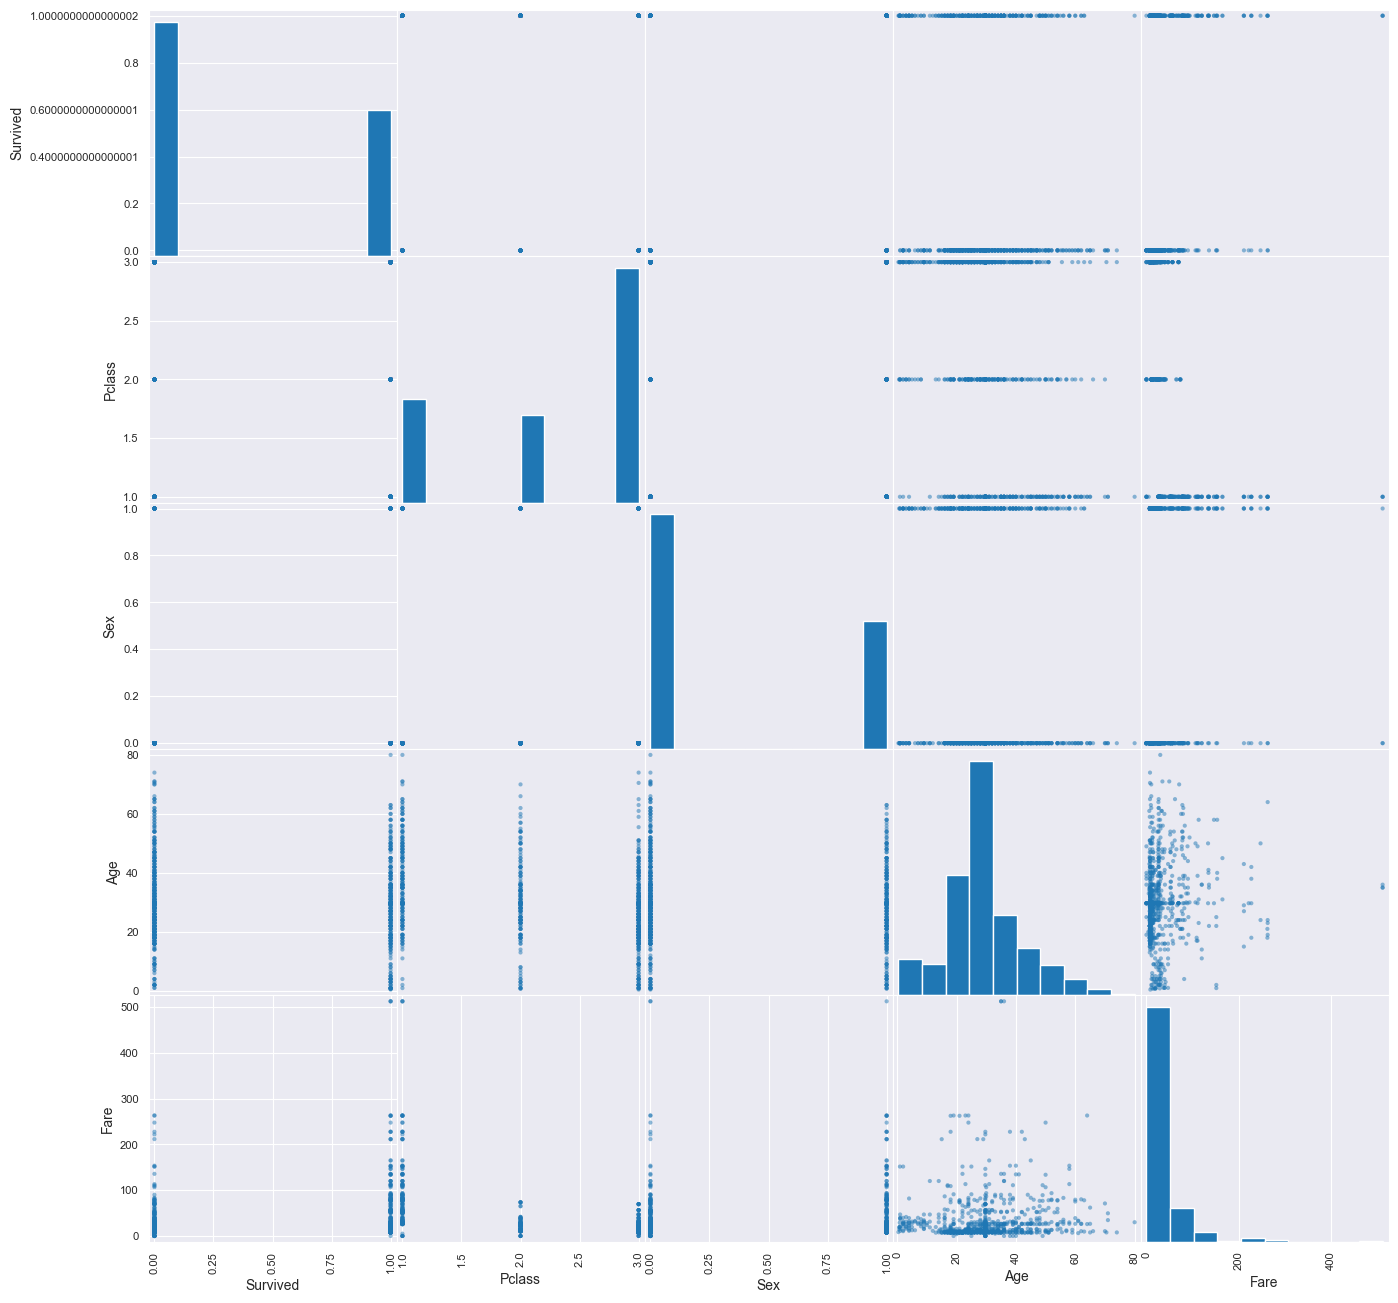

In [43]:
plt.figure(figsize=(16, 16))
pd.plotting.scatter_matrix(df.sample(len(df)), figsize=(16, 16))
plt.show()

Поділимо датасет на частини для тестування та тесту

In [44]:
reg_df = df
X, y = reg_df.drop('Survived', axis=1), reg_df['Survived']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 3. Використати декілька методів. Порівняти результати.

## Перша модель - лінійна регресія

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

y_pred_lg = model_lin.predict(X_test)

r2 = r2_score(y_test, y_pred_lg)
mse = mean_squared_error(y_test, y_pred_lg)
accuracy_lg = accuracy_score(y_test, np.round(y_pred_lg))

print(f"R-squared value: {r2}\nMean squared error: {mse}\nAccuracy rate: {accuracy_lg}")
print("Prediction:", np.round(y_pred_lg).astype(int))

R-squared value: 0.3300783006051201
Mean squared error: 0.1617881498679061
Accuracy rate: 0.776536312849162
Prediction: [1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1]


## Друга модель - поліноміальна регресія

In [47]:
from sklearn.preprocessing import PolynomialFeatures


model_pol = PolynomialFeatures(degree=2)

lg = LinearRegression()
lg.fit(model_pol.fit_transform(X_train), y_train)

y_pred_pol = np.round(lg.predict(model_pol.fit_transform(X_test)))
accuracy_pol = accuracy_score(y_test, y_pred_pol)

print(f"Accuracy rate: {accuracy_pol}\nPrediction: {y_pred_pol.astype(int)}")

Accuracy rate: 0.770949720670391
Prediction: [1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1]


## Третя модель - RandomForest

In [48]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
train_scale = std.fit_transform(X_train)
test_scale = std.fit_transform(X_test)

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=300, max_depth=15)
model_rf.fit(train_scale, y_train)
y_pred_rf = model_rf.predict(test_scale)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy rate: {accuracy_rf}\nPrediction: {y_pred_rf.astype(int)}")

Accuracy rate: 0.7932960893854749
Prediction: [1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1]


## Отже, всі три моделі на даному наборі даних показали приблизно однаковий результат точності, але відносно точна є модель RandomForest з точністю приблизно 79%